In [5]:
!pip3 install pycaret
!pip3 install pycountry_convert
!pip3 install seaborn
!pip3 install geopy
!pip3 install googletrans==3.1.0a0
!pip3 install sentence_transformers

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [6]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from pycaret.classification import *
from sklearn.metrics import  f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import pycountry_convert as pc
import re
import numpy as np

In [7]:
train = pd.read_csv('train.csv')
submission = pd.read_csv('submission.csv')

In [4]:
train.dtypes

bant_submit                float64
customer_country            object
business_unit               object
com_reg_ver_win_rate       float64
customer_idx                 int64
customer_type               object
enterprise                  object
historical_existing_cnt    float64
id_strategic_ver           float64
it_strategic_ver           float64
idit_strategic_ver         float64
customer_job                object
lead_desc_length             int64
inquiry_type                object
product_category            object
product_subcategory         object
product_modelname           object
customer_country.1          object
customer_position           object
response_corporate          object
expected_timeline           object
ver_cus                      int64
ver_pro                      int64
ver_win_rate_x             float64
ver_win_ratio_per_bu       float64
business_area               object
business_subarea            object
lead_owner                   int64
is_converted        

미처리한 컬럼
- 2. customer_country

# 1. bant_submit

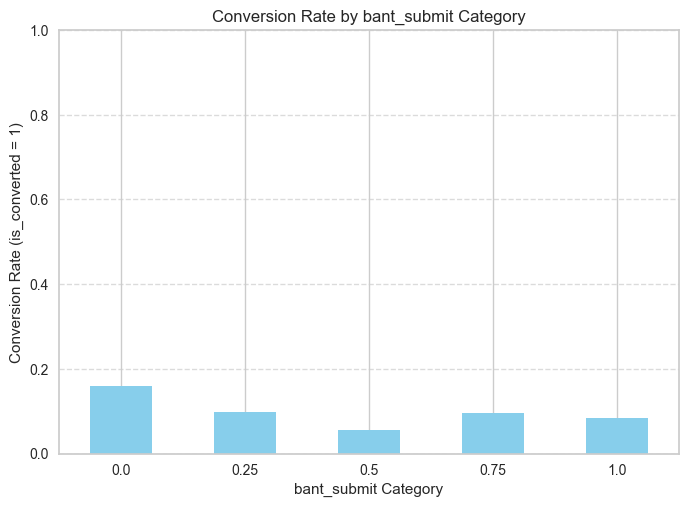

bant_sumit과 is_converted의 상관관계 : 

              bant_submit  is_converted
bant_submit       1.00000      -0.00248
is_converted     -0.00248       1.00000


In [5]:
cor = train[['bant_submit', 'is_converted']].corr()

conversion_rates = train.groupby('bant_submit')['is_converted'].mean()

# 그래프 생성
conversion_rates.plot(kind='bar', color='skyblue')
plt.title('Conversion Rate by bant_submit Category')
plt.xlabel('bant_submit Category')
plt.ylabel('Conversion Rate (is_converted = 1)')
plt.xticks(rotation=0)
plt.ylim(0, 1)  # y축 범위를 0부터 1까지로 설정
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f'bant_sumit과 is_converted의 상관관계 : \n\n{cor}')

# 2. customer_country
- 지호님 정리한 데이터 대체함


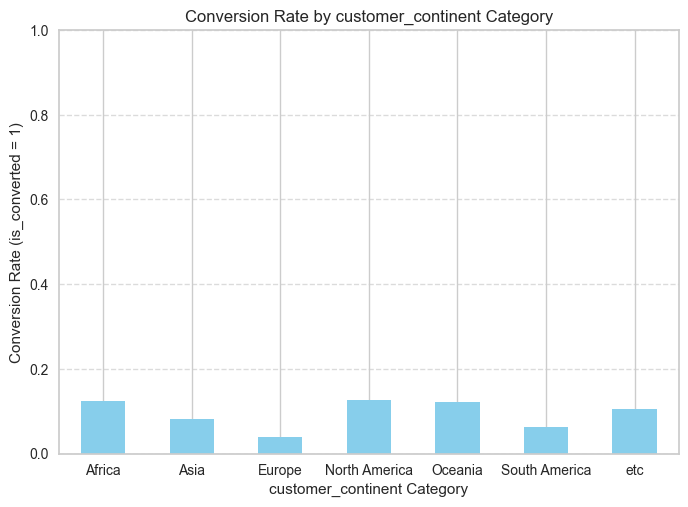

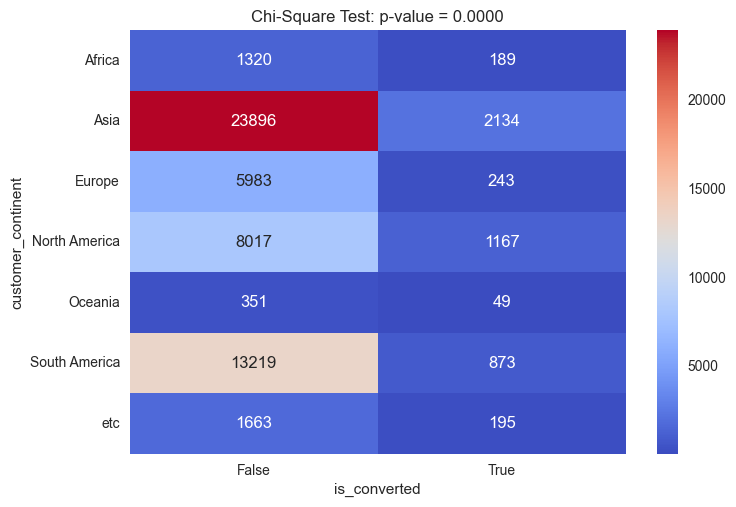

In [6]:
#지호님 데이터 추가
country_train = pd.read_csv('conversion_train_etc.csv')
country_sub = pd.read_csv('conversion_sub_etc.csv')
train['customer_country'] = country_train['customer_country']
submission['customer_country'] = country_sub['customer_country']

#pycountry 라이브러리 사용을 위해 인식하지 못하는 국가명을 다시 변환
country_names = {
    'The United Arab Emirates': 'United Arab Emirates',
    'Democratic Republic of Congo': 'Democratic Republic of the Congo',
    'Papua Niugini': 'Papua New Guinea',
    'The Savior': 'El Salvador',
    'Sri Lanka Sri Lanka': 'Sri Lanka',
    'korea': 'South Korea',
    'Deutschland': 'Germany',
    'Algérie ⵍⵣⵣⴰⵢⴻⵔ Algeria': 'Algeria',
    'Italia': 'Italy',
    'The Netherlands': 'Netherlands',
    'Viti': 'Fiji',
    'Cyprus - Kıbrıs': 'Cyprus',
    'Dhvehiraje': 'Serbia',
    'Maroc ⵍⵎⵖⵔⵉⴱ Morocco': 'Morocco',
    'Swisher': 'Switzerland',
    'The Bahamas': 'Bahamas',
    'Mongolia ᠮᠤᠩᠭᠤᠯ ᠤᠯᠤᠰ': 'Mongolia',
    'Soomaaliya Somalia': 'Somalia',
    'Maurice': 'Mauritius',
    'Hellas': 'Greece',
    'Benign': 'Benin',
    'in Swat': 'Pakistan',
    'Kosovo': 'Italy',                      #kosovo를 인식하지 못해서 다른 유럽 국가로 대체함
    'Djibouti Djibouti': 'Djibouti'
}

# 국가명 재변환을 위한 mapping 함수
def map_country(country):
    if country in country_names.keys():
        return country_names[country]
    else:
        return country
#country_names mapping
train['customer_country'] = train['customer_country'].apply(map_country)
submission['customer_country'] = submission['customer_country'].apply(map_country)

#나라를 대륙 명으로 변환하는 함수 
def country_to_continent(country_name):
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
    except Exception as e:
        if country_name == 'etc':
            return 'etc'
        return 'error'

train['customer_continent'] = train['customer_country'].apply(country_to_continent) 
submission['customer_continent'] = submission['customer_country'].apply(country_to_continent) 

#기존 컬럼 삭제
train.drop(columns=['customer_country'],inplace=True)
submission.drop(columns=['customer_country'],inplace=True)

conversion_rates = train.groupby('customer_continent')['is_converted'].mean()
chi2, p, _, _ = chi2_contingency(pd.crosstab(train['customer_continent'], train['is_converted']))

# 그래프 생성
conversion_rates.plot(kind='bar', color='skyblue')
plt.title('Conversion Rate by customer_continent Category')
plt.xlabel('customer_continent Category')
plt.ylabel('Conversion Rate (is_converted = 1)')
plt.xticks(rotation=0)
plt.ylim(0, 1)  # y축 범위를 0부터 1까지로 설정
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 시각화
sns.heatmap(pd.crosstab(train['customer_continent'], train['is_converted']), annot=True, cmap='coolwarm', fmt='d')
plt.title(f'Chi-Square Test: p-value = {p:.4f}')
plt.xlabel('is_converted')
plt.ylabel('customer_continent')
plt.show()

#원 핫 인코딩 
encoder = OneHotEncoder(drop='first')
#train 데이터 인코딩
encoder.fit(train[['customer_continent']])
train_encoded = encoder.transform(train[['customer_continent']])
#submission 데이터 인코딩
submission_encoded = encoder.transform(submission[['customer_continent']])

#인코딩 데이터 결합
train_encoded_df = pd.DataFrame(train_encoded.toarray(), columns=encoder.get_feature_names_out(['customer_continent']))
submission_encoded_df = pd.DataFrame(submission_encoded.toarray(), columns=encoder.get_feature_names_out(['customer_continent']))

train = pd.concat([train,train_encoded_df],axis=1)
submission = pd.concat([submission,submission_encoded_df],axis=1)

train.drop(columns=['customer_continent'],inplace=True)
submission.drop(columns=['customer_continent'],inplace=True)

In [7]:
train.dtypes

bant_submit                         float64
business_unit                        object
com_reg_ver_win_rate                float64
customer_idx                          int64
customer_type                        object
enterprise                           object
historical_existing_cnt             float64
id_strategic_ver                    float64
it_strategic_ver                    float64
idit_strategic_ver                  float64
customer_job                         object
lead_desc_length                      int64
inquiry_type                         object
product_category                     object
product_subcategory                  object
product_modelname                    object
customer_country.1                   object
customer_position                    object
response_corporate                   object
expected_timeline                    object
ver_cus                               int64
ver_pro                               int64
ver_win_rate_x                  

# 3 business_unit
- 카테고리의 수가 적은 'CM','Solution'은 'etc' 카테고리로 통합
- Ohe

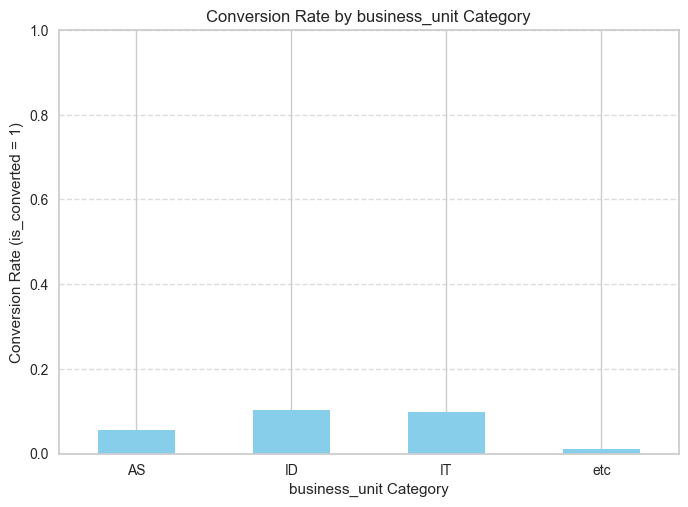

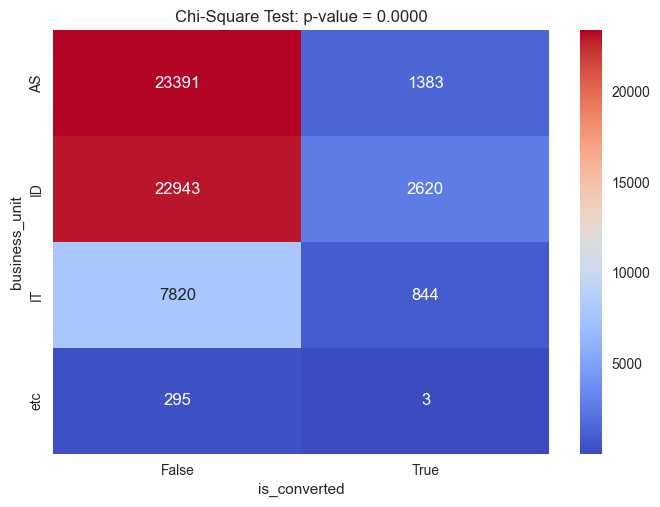

In [8]:
#CM, Solution Category 통합
train['business_unit'].replace({'CM':'etc','Solution':'etc'},inplace=True)
submission['business_unit'].replace({'CM':'etc','Solution':'etc'},inplace=True)

conversion_rates = train.groupby('business_unit')['is_converted'].mean()
chi2, p, _, _ = chi2_contingency(pd.crosstab(train['business_unit'], train['is_converted']))

# 그래프 생성
conversion_rates.plot(kind='bar', color='skyblue')
plt.title('Conversion Rate by business_unit Category')
plt.xlabel('business_unit Category')
plt.ylabel('Conversion Rate (is_converted = 1)')
plt.xticks(rotation=0)
plt.ylim(0, 1)  # y축 범위를 0부터 1까지로 설정
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 시각화
sns.heatmap(pd.crosstab(train['business_unit'], train['is_converted']), annot=True, cmap='coolwarm', fmt='d')
plt.title(f'Chi-Square Test: p-value = {p:.4f}')
plt.xlabel('is_converted')
plt.ylabel('business_unit')
plt.show()

#원 핫 인코딩 
encoder = OneHotEncoder(drop='first')
#train 데이터 인코딩
encoder.fit(train[['business_unit']])
train_encoded = encoder.transform(train[['business_unit']])
#submission 데이터 인코딩
submission_encoded = encoder.transform(submission[['business_unit']])

#인코딩 데이터 결합
train_encoded_df = pd.DataFrame(train_encoded.toarray(), columns=encoder.get_feature_names_out(['business_unit']))
submission_encoded_df = pd.DataFrame(submission_encoded.toarray(), columns=encoder.get_feature_names_out(['business_unit']))

train = pd.concat([train,train_encoded_df],axis=1)
submission = pd.concat([submission,submission_encoded_df],axis=1)

# 기존 칼럼 삭제 
train.drop(columns=['business_unit'],inplace=True)
submission.drop(columns=['business_unit'],inplace=True)

# 4 com_reg_ver_win_rate
fillna(0)

ANOVA 결과:
F-statistic: 1545.0549949575502
p-value: 0.0


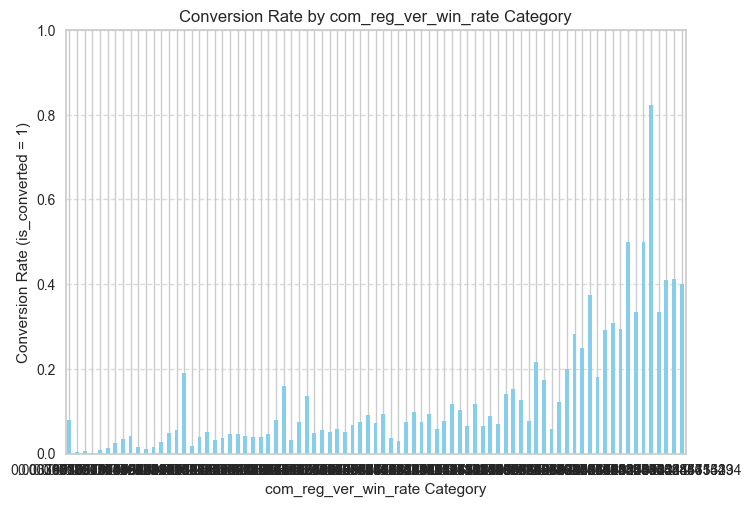

In [9]:
train['com_reg_ver_win_rate'].fillna(0,inplace=True)
submission['com_reg_ver_win_rate'].fillna(0,inplace=True)

# ANOVA 계산
anova_result = f_oneway(train[train['is_converted'] == 1]['com_reg_ver_win_rate'],
                        train[train['is_converted'] == 0]['com_reg_ver_win_rate'])

# ANOVA 결과 출력
print("ANOVA 결과:")
print("F-statistic:", anova_result.statistic)
print("p-value:", anova_result.pvalue)

# 시각화
conversion_rates = train.groupby('com_reg_ver_win_rate')['is_converted'].mean()
conversion_rates.plot(kind='bar', color='skyblue')
plt.title('Conversion Rate by com_reg_ver_win_rate Category')
plt.xlabel('com_reg_ver_win_rate Category')
plt.ylabel('Conversion Rate (is_converted = 1)')
plt.xticks(rotation=0)
plt.ylim(0, 1)  # y축 범위를 0부터 1까지로 설정
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# 5 customer_idx
- customer_idx의 희소 카테고리 (빈도수 5 이하)는 etc로 통일
- 이후 각 customer_idx를 mean_customer_idx (영업전환 성공률)로 대체함

0


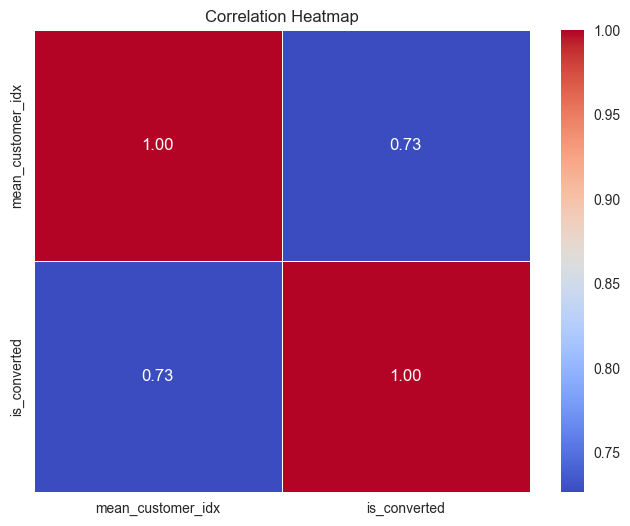

In [10]:
#customer_idx 형변환 int -> str
train['customer_idx'] = train['customer_idx'].astype(str)
submission['customer_idx'] = submission['customer_idx'].astype(str)

# customer_idx_cnt 컬럼 생성
train['customer_idx_cnt'] = train.groupby(['customer_idx'])['customer_idx'].transform('count')

#빈도 수 (customer_idx_cnt)가 5 이하인 데이터는 customer_idx를 etc로 통일
n = 5
for i in range(1,n+1):
    train.loc[train['customer_idx_cnt'] == i,'customer_idx'] = 'etc'

# customer_idx 별 평균 영업 성공률 계산한 mean_customer_idx 추가
train['mean_customer_idx'] = train.groupby('customer_idx')['is_converted'].transform('mean')
print(train['mean_customer_idx'].isna().sum())
mean_customer_idx_unique = train.drop_duplicates(subset=['customer_idx'])[['customer_idx', 'mean_customer_idx']]
submission = submission.merge(mean_customer_idx_unique, on='customer_idx', how='left')
#submission에서 매칭되지 않은(etc에 속한 customer_idx 또는 submission에만 존재하는 customer_idx) mean_customer_idx의 값은 etc에 해당하는 값으로 대체
submission['mean_customer_idx'].fillna(train[train['customer_idx']=='etc']['mean_customer_idx'][0],inplace= True)

train.drop(columns = ['customer_idx_cnt'],inplace=True)

plt.figure(figsize=(8, 6))
sns.heatmap(train[['mean_customer_idx','is_converted']].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# 6. customer_type
- 카테고리 통합
- Ohe

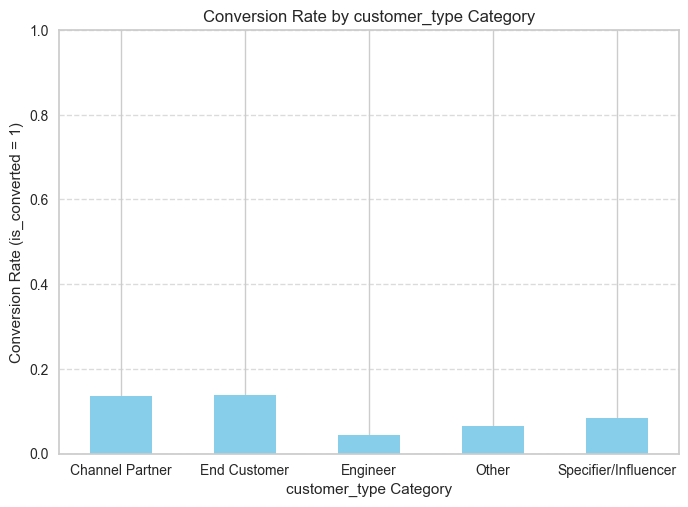

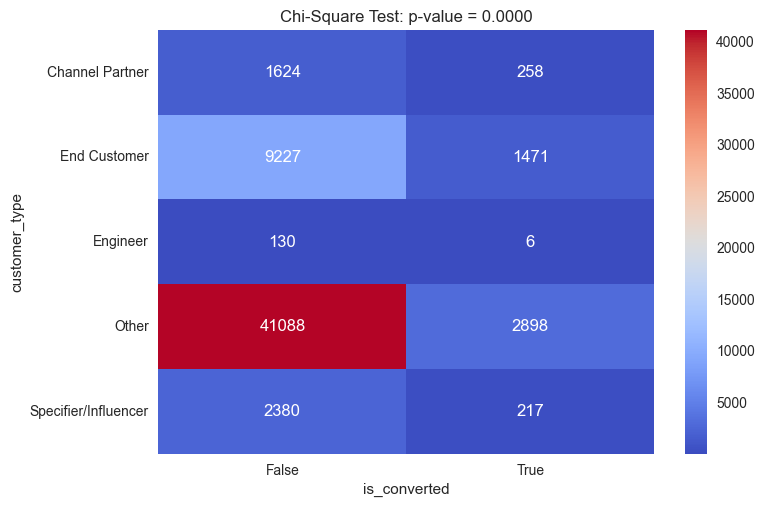

In [11]:
customer_types = {
    'End-Customer': 'End Customer',
    'End-user': 'End Customer',
    'Corporate': 'End Customer',
    'End Customer': 'End Customer',
    'Homeowner': 'End Customer',
    'Home Owner': 'End Customer',
    'Commercial end-user': 'End Customer',
    'Specifier/ Influencer': 'Specifier/Influencer',
    'Specifier / Influencer': 'Specifier/Influencer',
    'Architect/Consultant': 'Specifier/Influencer',
    'Manager / Director': 'Specifier/Influencer',
    'Consultant': 'Specifier/Influencer',
    'Administrator': 'Specifier/Influencer',
    'Developer': 'Engineer',
    'Engineer': 'Engineer',
    'HVAC Engineer': 'Engineer',
    'System Integrator': 'Engineer',
    'Installer': 'Engineer',
    'Installer/Contractor': 'Engineer',
    'Technician': 'Engineer',
    'Technical Assistant': 'Engineer',
    'Technician': 'Engineer',
    'Service Partner': 'Channel Partner',
    'Channel Partner': 'Channel Partner',
    'Solution Eco-Partner': 'Channel Partner',
    'Distributor': 'Channel Partner',
    'Reseller': 'Channel Partner',
    'Dealer/Distributor': 'Channel Partner',
    'Software/Solution Provider': 'Channel Partner',
    'Software / Solution Provider': 'Channel Partner',
    'Dealer': 'Channel Partner',
    'Others': 'Other',
    'Etc.': 'Other',
    'Interior Designer': 'Other'
}

# mapping 함수 정의
def map_customer_type(type):
    if type in customer_types.keys():
        return customer_types[type]
    else:
        return type

# Mapping
train['customer_type'] = train['customer_type'].map(map_customer_type)
submission['customer_type'] = submission['customer_type'].map(map_customer_type)
# 결측값은 Other로 변환
train['customer_type'].fillna('Other',inplace=True)
submission['customer_type'].fillna('Other',inplace=True)

conversion_rates = train.groupby('customer_type')['is_converted'].mean()
chi2, p, _, _ = chi2_contingency(pd.crosstab(train['customer_type'], train['is_converted']))

# 그래프 생성
conversion_rates.plot(kind='bar', color='skyblue')
plt.title('Conversion Rate by customer_type Category')
plt.xlabel('customer_type Category')
plt.ylabel('Conversion Rate (is_converted = 1)')
plt.xticks(rotation=0)
plt.ylim(0, 1)  # y축 범위를 0부터 1까지로 설정
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 시각화
sns.heatmap(pd.crosstab(train['customer_type'], train['is_converted']), annot=True, cmap='coolwarm', fmt='d')
plt.title(f'Chi-Square Test: p-value = {p:.4f}')
plt.xlabel('is_converted')
plt.ylabel('customer_type')
plt.show()

#원 핫 인코딩 
encoder = OneHotEncoder(drop='first')
#train 데이터 인코딩
encoder.fit(train[['customer_type']])
train_encoded = encoder.transform(train[['customer_type']])
#submission 데이터 인코딩
submission_encoded = encoder.transform(submission[['customer_type']])

#인코딩 데이터 결합
train_encoded_df = pd.DataFrame(train_encoded.toarray(), columns=encoder.get_feature_names_out(['customer_type']))
submission_encoded_df = pd.DataFrame(submission_encoded.toarray(), columns=encoder.get_feature_names_out(['customer_type']))

train = pd.concat([train,train_encoded_df],axis=1)
submission = pd.concat([submission,submission_encoded_df],axis=1)

# 기존 칼럼 삭제 
train.drop(columns=['customer_type'],inplace=True)
submission.drop(columns=['customer_type'],inplace=True)

# 7. enterprise
- Ohe

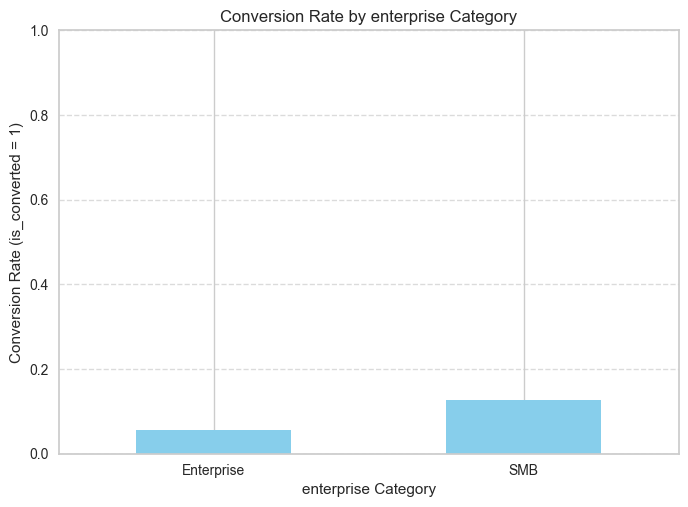

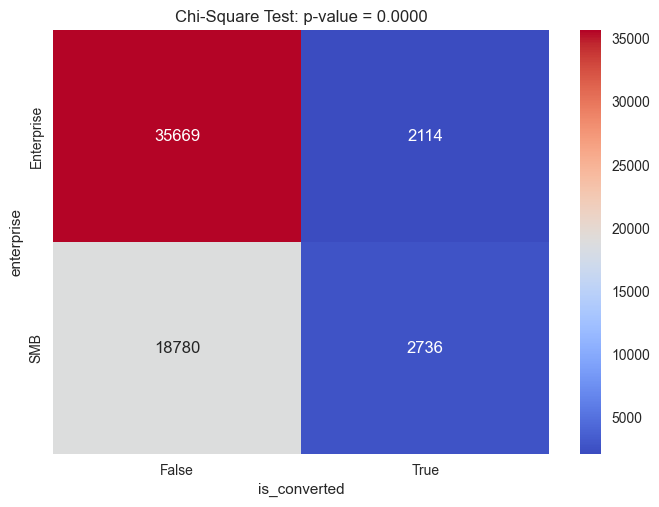

In [12]:
conversion_rates = train.groupby('enterprise')['is_converted'].mean()
chi2, p, _, _ = chi2_contingency(pd.crosstab(train['enterprise'], train['is_converted']))

# 그래프 생성
conversion_rates.plot(kind='bar', color='skyblue')
plt.title('Conversion Rate by enterprise Category')
plt.xlabel('enterprise Category')
plt.ylabel('Conversion Rate (is_converted = 1)')
plt.xticks(rotation=0)
plt.ylim(0, 1)  # y축 범위를 0부터 1까지로 설정
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 시각화
sns.heatmap(pd.crosstab(train['enterprise'], train['is_converted']), annot=True, cmap='coolwarm', fmt='d')
plt.title(f'Chi-Square Test: p-value = {p:.4f}')
plt.xlabel('is_converted')
plt.ylabel('enterprise')
plt.show()

#원 핫 인코딩 
encoder = OneHotEncoder(drop='first')
#train 데이터 인코딩
encoder.fit(train[['enterprise']])
train_encoded = encoder.transform(train[['enterprise']])
#submission 데이터 인코딩
submission_encoded = encoder.transform(submission[['enterprise']])

#인코딩 데이터 결합
train_encoded_df = pd.DataFrame(train_encoded.toarray(), columns=encoder.get_feature_names_out(['enterprise']))
submission_encoded_df = pd.DataFrame(submission_encoded.toarray(), columns=encoder.get_feature_names_out(['enterprise']))

train = pd.concat([train,train_encoded_df],axis=1)
submission = pd.concat([submission,submission_encoded_df],axis=1)

# 기존 칼럼 삭제 
train.drop(columns=['enterprise'],inplace=True)
submission.drop(columns=['enterprise'],inplace=True)

# 8. historical_existing_cnt 
- 결측값은 0으로, historical_existing_cnt_isna(컬럼 추가) 는 해당 시점에서 과거의 영업 시도 경험이 없으면 1, 있으면 0

- 결측값과 이상값을 제거한 historical_existing_cnt의 분포


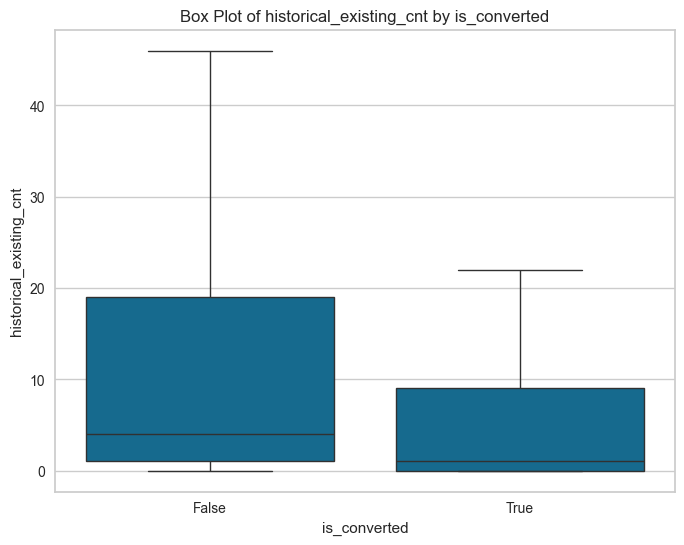

historical_existing_cnt 와 is_converted의 상관계수 : 

                         historical_existing_cnt  is_converted
historical_existing_cnt                  1.00000      -0.00449
is_converted                            -0.00449       1.00000




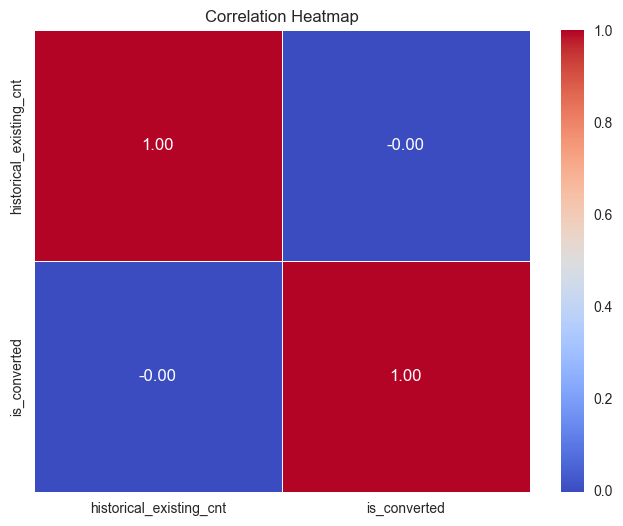

결측값 존재 여부를 분류한 컬럼의 시각화


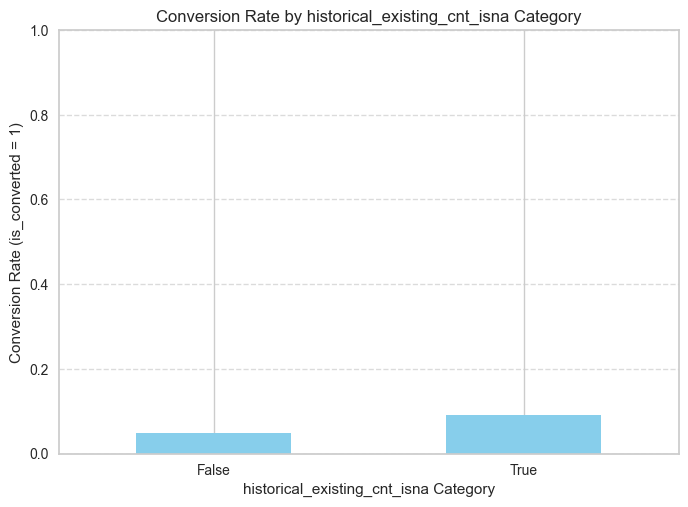

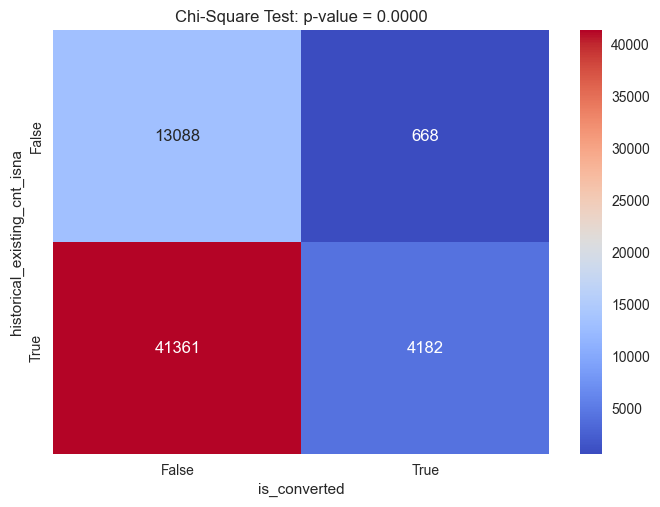

In [13]:
print('- 결측값과 이상값을 제거한 historical_existing_cnt의 분포')

plt.figure(figsize=(8, 6))
sns.boxplot(x='is_converted', y='historical_existing_cnt',showfliers=False, data=train[~train['historical_existing_cnt'].isna()])
plt.title('Box Plot of historical_existing_cnt by is_converted')
plt.xlabel('is_converted')
plt.ylabel('historical_existing_cnt')
plt.show()

cor = train[['historical_existing_cnt', 'is_converted']].corr()
print(f'historical_existing_cnt 와 is_converted의 상관계수 : \n\n{cor}\n\n')

#hitmap
plt.figure(figsize=(8, 6))
sns.heatmap(train[['historical_existing_cnt','is_converted']].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

print("결측값 존재 여부를 분류한 컬럼의 시각화")

#historical_existing_cnt_isna 생성
train['historical_existing_cnt_isna'] = train['historical_existing_cnt'].isna()
submission['historical_existing_cnt_isna'] = submission['historical_existing_cnt'].isna()

conversion_rates = train.groupby('historical_existing_cnt_isna')['is_converted'].mean()
chi2, p, _, _ = chi2_contingency(pd.crosstab(train['historical_existing_cnt_isna'], train['is_converted']))

# 그래프 생성
conversion_rates.plot(kind='bar', color='skyblue')
plt.title('Conversion Rate by historical_existing_cnt_isna Category')
plt.xlabel('historical_existing_cnt_isna Category')
plt.ylabel('Conversion Rate (is_converted = 1)')
plt.xticks(rotation=0)
plt.ylim(0, 1)  # y축 범위를 0부터 1까지로 설정
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 시각화
sns.heatmap(pd.crosstab(train['historical_existing_cnt_isna'], train['is_converted']), annot=True, cmap='coolwarm', fmt='d')
plt.title(f'Chi-Square Test: p-value = {p:.4f}')
plt.xlabel('is_converted')
plt.ylabel('historical_existing_cnt_isna')
plt.show()

#fillna(0)
train['historical_existing_cnt'].fillna(0,inplace=True)
submission['historical_existing_cnt'].fillna(0,inplace=True)



# 9. id_strategic_ver
- fillna(0)

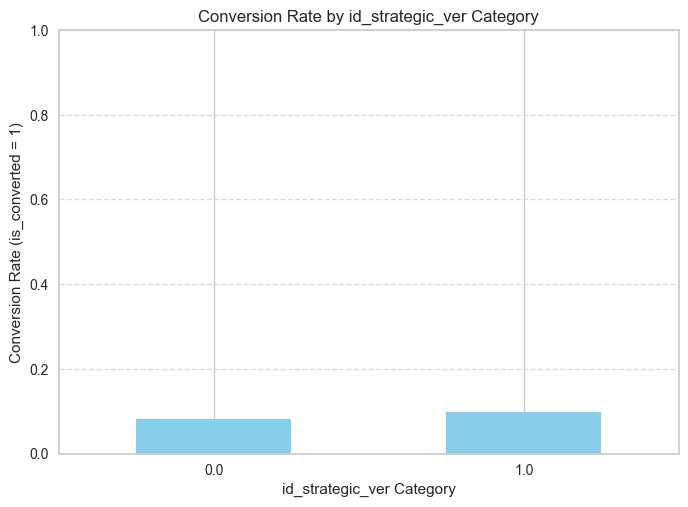

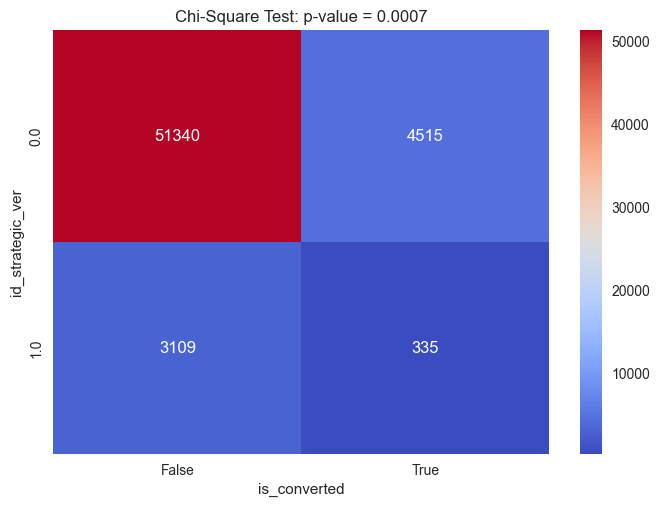

In [14]:
train['id_strategic_ver'].fillna(0,inplace=True)
submission['id_strategic_ver'].fillna(0,inplace=True)

conversion_rates = train.groupby('id_strategic_ver')['is_converted'].mean()
chi2, p, _, _ = chi2_contingency(pd.crosstab(train['id_strategic_ver'], train['is_converted']))

# 그래프 생성
conversion_rates.plot(kind='bar', color='skyblue')
plt.title('Conversion Rate by id_strategic_ver Category')
plt.xlabel('id_strategic_ver Category')
plt.ylabel('Conversion Rate (is_converted = 1)')
plt.xticks(rotation=0)
plt.ylim(0, 1)  # y축 범위를 0부터 1까지로 설정
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 시각화
sns.heatmap(pd.crosstab(train['id_strategic_ver'], train['is_converted']), annot=True, cmap='coolwarm', fmt='d')
plt.title(f'Chi-Square Test: p-value = {p:.4f}')
plt.xlabel('is_converted')
plt.ylabel('id_strategic_ver')
plt.show()

# 10. it_strategic_ver
- fillna(0)

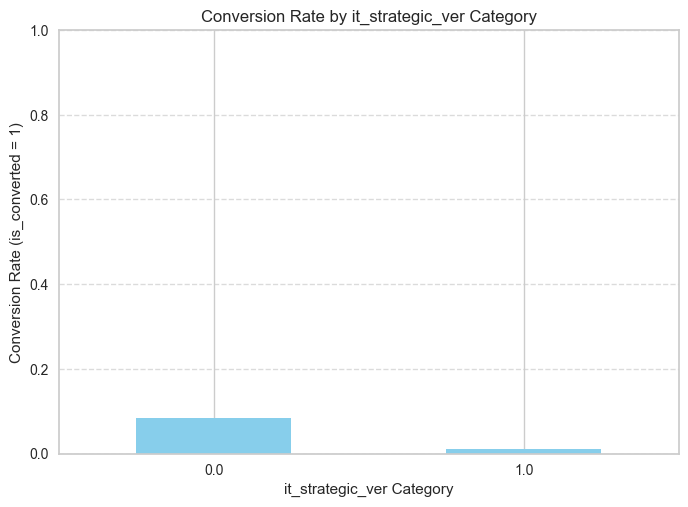

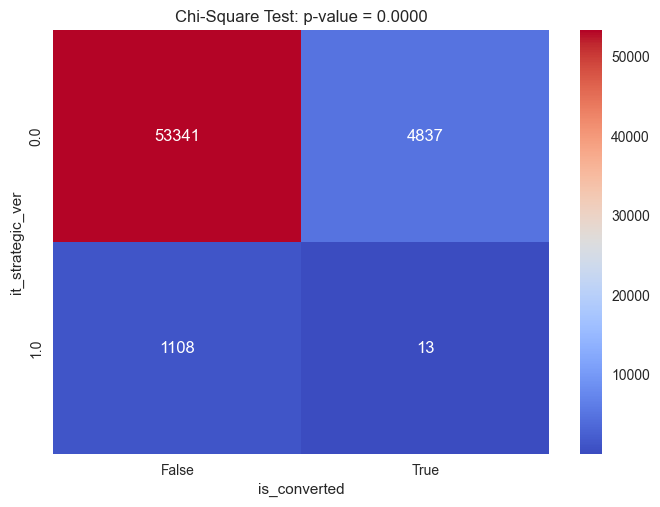

In [15]:
train['it_strategic_ver'].fillna(0,inplace=True)
submission['it_strategic_ver'].fillna(0,inplace=True)

conversion_rates = train.groupby('it_strategic_ver')['is_converted'].mean()
chi2, p, _, _ = chi2_contingency(pd.crosstab(train['it_strategic_ver'], train['is_converted']))

# 그래프 생성
conversion_rates.plot(kind='bar', color='skyblue')
plt.title('Conversion Rate by it_strategic_ver Category')
plt.xlabel('it_strategic_ver Category')
plt.ylabel('Conversion Rate (is_converted = 1)')
plt.xticks(rotation=0)
plt.ylim(0, 1)  # y축 범위를 0부터 1까지로 설정
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 시각화
sns.heatmap(pd.crosstab(train['it_strategic_ver'], train['is_converted']), annot=True, cmap='coolwarm', fmt='d')
plt.title(f'Chi-Square Test: p-value = {p:.4f}')
plt.xlabel('is_converted')
plt.ylabel('it_strategic_ver')
plt.show()

# 11. idit_strategic_ver
- fillna(0)

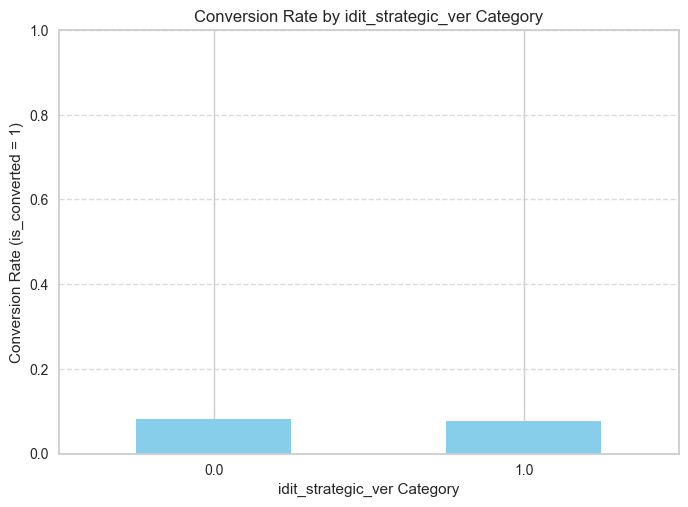

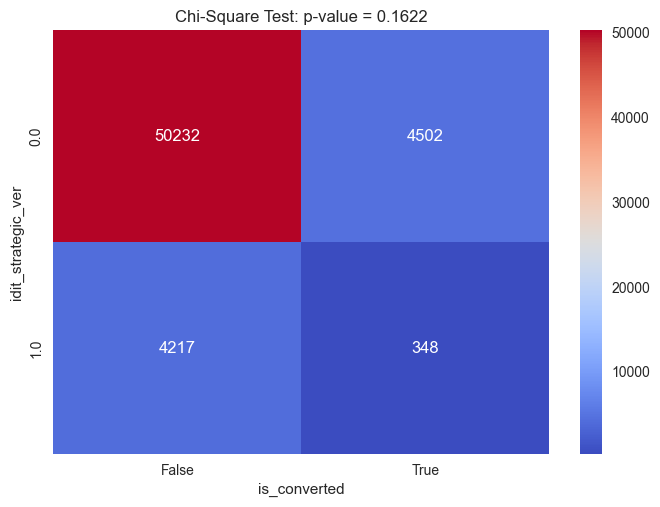

In [16]:
train['idit_strategic_ver'].fillna(0,inplace=True)
submission['idit_strategic_ver'].fillna(0,inplace=True)

conversion_rates = train.groupby('idit_strategic_ver')['is_converted'].mean()
chi2, p, _, _ = chi2_contingency(pd.crosstab(train['idit_strategic_ver'], train['is_converted']))

# 그래프 생성
conversion_rates.plot(kind='bar', color='skyblue')
plt.title('Conversion Rate by idit_strategic_ver Category')
plt.xlabel('idit_strategic_ver Category')
plt.ylabel('Conversion Rate (is_converted = 1)')
plt.xticks(rotation=0)
plt.ylim(0, 1)  # y축 범위를 0부터 1까지로 설정
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 시각화
sns.heatmap(pd.crosstab(train['idit_strategic_ver'], train['is_converted']), annot=True, cmap='coolwarm', fmt='d')
plt.title(f'Chi-Square Test: p-value = {p:.4f}')
plt.xlabel('is_converted')
plt.ylabel('idit_strategic_ver')
plt.show()

# 12 customer_job(미완성)

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

from googletrans import Translator
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import WordPunctTokenizer

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer, util

[nltk_data] Downloading package stopwords to /Users/sindong-
[nltk_data]     ugwanlija/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
def translate_func(text, attempt = 1, max_attempt = 5):
    translator = Translator()
    try:
        return translator.translate(text, dest = "en").text  # 번역
    except:          # 에러의 경우
        if attempt <= max_attempt:   # 5번 이하로 다시 시도
            return translate_func(text, attempt = attempt + 1)
        raise

In [19]:
original = len(set(train.customer_job))

In [20]:
# 번역
job_lst = set(train.customer_job)
job_lst_trans = [translate_func(i) if not pd.isna(i) else i for i in job_lst] 
job_dict = pd.DataFrame([job_lst, job_lst_trans]).T
job_dict.columns = ["job_lst", "job_lst_trans"]
job_dict = job_dict.set_index("job_lst").T.to_dict()
train.customer_job = [job_dict[i]["job_lst_trans"] if not pd.isna(i) else i for i in train.customer_job]

job_lst = set(submission.customer_job)
job_lst_trans = [translate_func(i) if not pd.isna(i) else i for i in job_lst] 
job_dict = pd.DataFrame([job_lst, job_lst_trans]).T
job_dict.columns = ["job_lst", "job_lst_trans"]
job_dict = job_dict.set_index("job_lst").T.to_dict()
submission.customer_job = [job_dict[i]["job_lst_trans"] if not pd.isna(i) else i for i in submission.customer_job]

In [22]:
original_trans = len(set(train.customer_job))

In [23]:
# 방법 2. 사전학습모델 SentenceTransformer
# 단어의 숨겨진 의미까지 파악해 위 방법보다 유연
model = SentenceTransformer('paraphrase-distilroberta-base-v1')
customer_set = sorted(list(set(train.customer_job.dropna())))
le_train = len(customer_set)

# 특수문자 제거 및 토큰화
customer_re = [re.sub(r"[.,~!@#$%^&*\(\)_+=\-~|\\\"\';:\?/\<\>\[\]\{\}]", " ", customer) for customer in customer_set]
customer_re = [customer.strip().lower() for customer in customer_re]
customer_token = [WordPunctTokenizer().tokenize(i) for i in customer_re]

# 불용어 사전
stop = stopwords.words('english')
stop.remove("it") # IT 때문에 삭제

# 불용어 제거
customer_stop = []
for i in customer_token:
    for j in i:
        sent = i
        if j in stop: # 불용어 사전에 있으면 제거
            sent.remove(j)
    customer_stop.append(sent)
customer_stop = [" ".join(i) for i in customer_stop] # 다시 결합

embeddings = model.encode(customer_stop, convert_to_tensor=True)

In [24]:
import numpy as np
import pandas as pd
import torch

# 방법 2-3. 방법 1-3과 동일
standard = 0.6

# embeddings가 PyTorch tensor로 가정됨
# embeddings를 CPU로 이동시킴
embeddings_cpu = embeddings.cpu()

cosine_scores = util.pytorch_cos_sim(embeddings_cpu, embeddings_cpu)
cosine_scores = np.array(cosine_scores)
np.fill_diagonal(cosine_scores, np.nan)

cos_similar = dict()
cosine_scores = pd.DataFrame(cosine_scores)
c = customer_stop.copy()
while cosine_scores.max().max() > standard:
    i = cosine_scores.max(axis = 1).idxmax()
    j = cosine_scores.iloc[i,:].idxmax()
    
    cosine_scores.iloc[i, j] = 0
    cosine_scores.iloc[j, i] = 0

    idx, del_idx = [i, j] if len(c[i]) <= len(c[j]) else [j, i]
    
    if c[idx] == "":
        idx, del_idx = del_idx, idx
    elif c[idx] in cos_similar.keys():
        cos_similar[c[del_idx]] = cos_similar[c[idx]]
    else:
        cos_similar[c[del_idx]] = c[idx]
    
    cosine_scores = cosine_scores.drop(del_idx).drop(del_idx, axis = 1).reset_index(drop = True)
    cosine_scores.columns = list(range(len(cosine_scores)))
    del c[del_idx]
    
c = [cos_similar[i] if i in cos_similar.keys() else i for i in customer_stop]

# train의 customer_job 변경
customer_df_train = pd.DataFrame([customer_set, c]).T  # DataFrame 생성
customer_df_train.columns = ["customer_set", "c"]            # colunm명 생성
customer_dict_train = customer_df_train.set_index("customer_set").T.to_dict()   # dict형으로 변환
customer_job_t = [customer_dict_train[i]["c"] if not pd.isna(i) and customer_dict_train[i]["c"] != "" else i for i in train.customer_job] # country 기준 conversion으로 변경
len_6 = len(set(customer_job_t))
len_6


317

In [25]:
# manage라는 단어를 포함한 단어들이 어떻게 변경되었는지 확인
manage = [i for i in customer_set if "manage" in i]
manage_trans_6 = [customer_dict_train[i]["c"] if not pd.isna(i) and customer_dict_train[i]["c"] != "" else i for i in manage]

In [26]:
# 어떤 값이 변화되었는지 확인하기 위한 코드
# key 값이 변화된 값, value가 변화되기 전의 값으로 구성
def test_func(cos_similar):
    test = dict()
    for i in cos_similar.keys():
        if cos_similar[i] not in test.keys():
            test[cos_similar[i]] = [i]
        else:
            test[cos_similar[i]] += [i]
    return test
test_func(cos_similar)

{'medical solution provider': ['medical solution provider',
  'medical solution provider \u200b'],
 'estimator': ['estimator'],
 'human resources': ['human resources'],
 'quality assurance': ['quality assurance'],
 'military protective services': ['military protective services'],
 'healthcare services': ['healthcare services', 'healthcare professionals'],
 'radiology professional': ['radiology professional'],
 'business development': ['business development'],
 'community social services': ['community social services'],
 'sourcing': ['sourcing procurement'],
 'installer': ['installer',
  'installation purchaser',
  'installer sales rep',
  'seller installer'],
 'program project manager': ['program project management'],
 'design': ['art design', 'design build', 'designer', 'design purchaser'],
 'tech': ['tech',
  'information technology',
  'technical',
  'it tech',
  'tech service',
  'energy'],
 'media': ['media communication'],
 'director': ['director it',
  'it director',
  'director

# 13 lead_desc_length

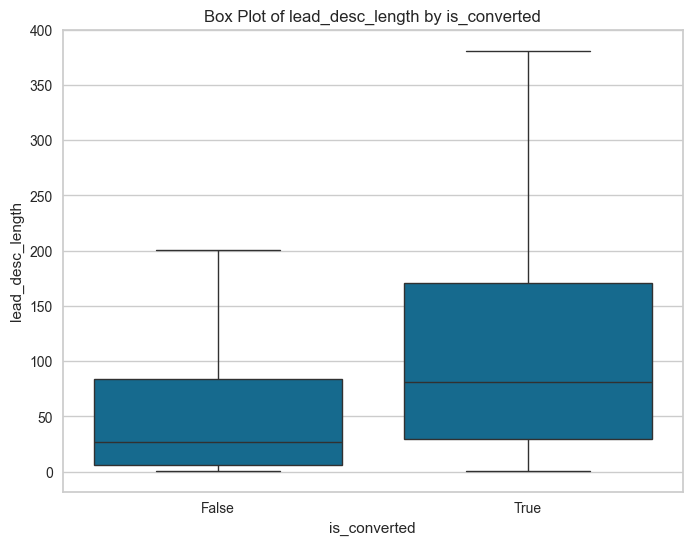

lead_desc_length 와 is_converted의 상관계수 : 

                  lead_desc_length  is_converted
lead_desc_length          1.000000      0.112822
is_converted              0.112822      1.000000




In [27]:
# 이상치 제거
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_converted', y='lead_desc_length',showfliers=False, data=train)
plt.title('Box Plot of lead_desc_length by is_converted')
plt.xlabel('is_converted')
plt.ylabel('lead_desc_length')
plt.show()

cor = train[['lead_desc_length', 'is_converted']].corr()
print(f'lead_desc_length 와 is_converted의 상관계수 : \n\n{cor}\n\n')


# 14 inquiry_type(미완성)

In [28]:
train.drop(columns=['inquiry_type'],inplace=True)
submission.drop(columns=['inquiry_type'],inplace=True)

# 15 product_category(미완성)

In [9]:
# response_corporate 변수의 고유한 값 출력
unique_categories = train['product_category'].unique()
print("Unique categories in 'product_category':")
print(unique_categories)

Unique categories in 'product_category':
['multi-split' 'single-split' 'vrf' 'chiller' 'etc.' 'rac'
 'teto ou cassete inverter' nan 'software solution' 'all lg vrf systems'
 'ventilation' 'a thermodynamic water heater'
 'residential air conditioner' 'outros' 'heating' 'multi v5 vrf'
 'split tunggal' 'multi inverter' 'חימום' 'standard signage'
 'high brightness signage' 'interactive signage' 'video wall signage'
 'led signage' 'hotel tv' 'signage care solution' 'oled signage' 'idb'
 'video wall' 'one:quick series' 'commercial tv' 'lg one:quick'
 'special signage' 'other' 'accessories' 'commercial display'
 'interactive digital board' 'standard' 'uhd signage' 'smart tv signage'
 'lg one:quick series' 'pro:centric' 'ur640' 'ur640s' 'webos'
 'signage care solutions' 'aio | one quick' 'high brightness'
 'hospital tv' 'digital signage' 'monitor' 'pc' 'laptop' 'projector'
 'cloud device' 'medical display' 'washing machine,dryer' 'solar,chiller'
 'system ac,rac' 'monitor signage,commercial tv,

In [29]:
train.drop(columns=['product_category'],inplace=True)
submission.drop(columns=['product_category'],inplace=True)

# 16 product_subcategory(미완성)

In [30]:
train.drop(columns=['product_subcategory'],inplace=True)
submission.drop(columns=['product_subcategory'],inplace=True)

# 17 product_modelname (미완성)

In [31]:
def is_specific_model_name(entry):
    """
    Determines if an entry is likely a specific model name based on predefined rules.
    
    Args:
    - entry (str): The string to be evaluated.
    
    Returns:
    - int: 1 if the entry is likely a specific model name, otherwise 0.
    """
    
    # Check if entry is not a string (e.g., NaN or None)
    if not isinstance(entry, str):
        return 0  # Assume non-strings are not specific model names
    
    # Rule 1: Exclude obvious non-model entries based on common keywords
    common_non_model_keywords = ["service", "need", "inquiry", "meeting", "only", "want", "all"]
    if any(keyword in entry.lower() for keyword in common_non_model_keywords):
        return 0
    
    # Rule 2: Check for alphanumeric patterns typical of model names
    if re.search(r'\d', entry) and re.search(r'[A-Z]', entry):
        # Rule 3: Check for presence of specific special characters
        if re.search(r'[-()_/]', entry) or re.search(r'\d{2,}', entry):
            return 1
    
    # Default to non-specific if no rules matched
    return 0

train['product_modelname'] = train['product_modelname'].apply(is_specific_model_name)

# 18 customer_country.1(중복 컬럼이라서 삭제)

In [32]:
# 중복 컬럼 삭제
train.drop(columns=['customer_country.1'],inplace=True)
submission.drop(columns=['customer_country.1'],inplace=True)

# 19 customer_position
customer_position_power 추가

In [33]:
train['customer_position'].isnull().sum()
submission['customer_position'].isnull().sum()


0

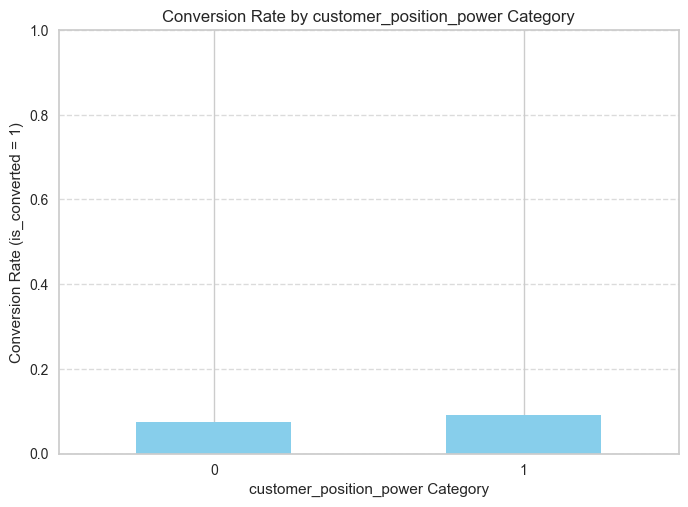

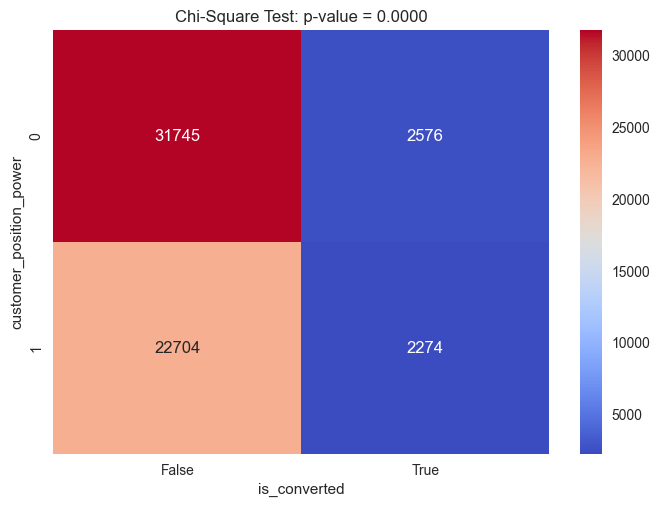

In [34]:
def categorize_position(position):
    if pd.isnull(position):
        return 0  # 결측값인 경우 0으로 처리
    high_power_positions = ['ceo/founder', 'c-level executive', 'vice president', 'director', 'partner', 'manager', 'business unit director', 'chief executive officer', 'chairman', 'president', 'decision maker', 'decision-maker']
    position_normalized = position.lower().replace(" ", "")
    for high_power_position in high_power_positions:
        if high_power_position.replace(" ", "") in position_normalized:
            return 1
    return 0

train['customer_position_power'] = train['customer_position'].apply(categorize_position)
submission['customer_position_power'] = submission['customer_position'].apply(categorize_position)

conversion_rates = train.groupby('customer_position_power')['is_converted'].mean()
chi2, p, _, _ = chi2_contingency(pd.crosstab(train['customer_position_power'], train['is_converted']))

# 그래프 생성
conversion_rates.plot(kind='bar', color='skyblue')
plt.title('Conversion Rate by customer_position_power Category')
plt.xlabel('customer_position_power Category')
plt.ylabel('Conversion Rate (is_converted = 1)')
plt.xticks(rotation=0)
plt.ylim(0, 1)  # y축 범위를 0부터 1까지로 설정
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 시각화
sns.heatmap(pd.crosstab(train['customer_position_power'], train['is_converted']), annot=True, cmap='coolwarm', fmt='d')
plt.title(f'Chi-Square Test: p-value = {p:.4f}')
plt.xlabel('is_converted')
plt.ylabel('customer_position_power')
plt.show()

train.drop(columns=['customer_position'],inplace=True)
submission.drop(columns=['customer_position'],inplace=True)


# 20 response_corporate
- corporate가 속한 지역을 뜻하는 region_continents 컬럼 추가
- drop

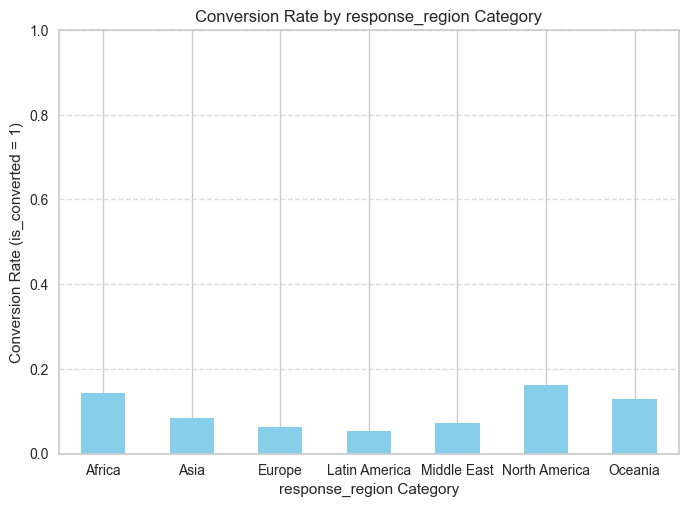

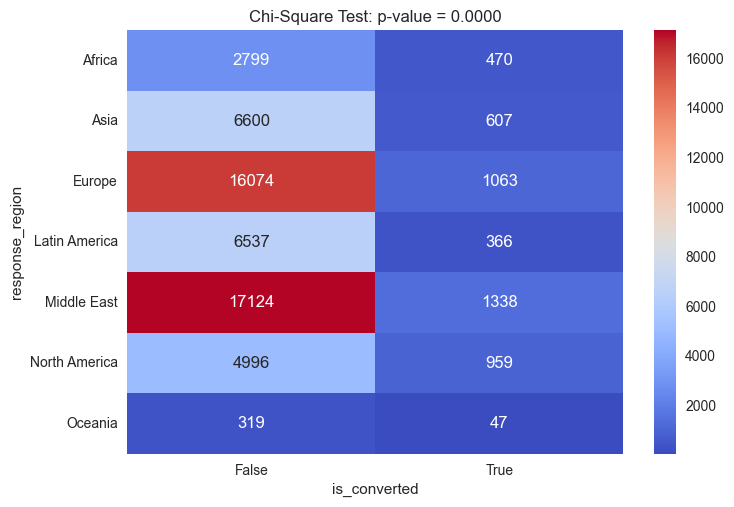

In [35]:
response_corporate_region = {
    'LGEPH': 'Asia',
    'LGEIL': 'Middle East',
    'LGEAF': 'Africa',
    'LGESJ': 'Europe',
    'LGESL': 'Europe',
    'LGESP': 'Europe',
    'LGEGF': 'Africa',
    'LGESA': 'Middle East',
    'LGEUS': 'North America',
    'LGECB': 'Latin America',
    'LGEMS': 'Asia',
    'LGEEG': 'Middle East',
    'LGEEF': 'Africa',
    'LGEAP': 'Oceania',
    'LGEIN': 'Asia',
    'LGEUK': 'Europe',
    'LGEKR': 'Asia',
    'LGEPS': 'Latin America',
    'LGECI': 'Africa',
    'LGECL': 'Latin America',
    'LGETK': 'Europe',
    'LGELF': 'Europe',
    'LGEPT': 'Europe',
    'LGEPR': 'Latin America',
    'LGEDG': 'Latin America',
    'LGERO': 'Europe',
    'LGEMK': 'Europe',
    'LGEPL': 'Europe',
    'LGECZ': 'Europe',
    'LGEES': 'Europe',
    'LGEAR': 'Middle East',
    'LGEHK': 'Asia',
    'LGEML': 'Africa',
    'LGEJP': 'Asia',
    'LGEHS': 'Latin America',
    'LGEAS': 'Asia',
    'LGEYK': 'Middle East',
    'LGEIS': 'Europe',
    'LGEBN': 'Africa',
    'LGEFS': 'Europe',
    'LGESW': 'Europe',
    'LGEMC': 'Europe',
    'LGEAG': 'Africa',
    'LGEEB': 'Middle East',
    'LGETH': 'Africa',
    'LGEVH': 'Asia',
    'LGECH': 'Europe',
    'LGELA': 'Asia',
    'LGETT': 'Europe',
    'LGERA': 'Africa',
    'LGEUR': 'Europe',
    'LGEIR': 'Europe',
    'LGEBT': 'Asia'
}
# 결측값을 처리하는 함수 정의
def categorize_response_corporate(response_corporate):
    if pd.isnull(response_corporate):  # 결측값인 경우 'Unknown'으로 처리
        return 'Unknown'
    else:
        return response_corporate_region.get(response_corporate, 'Unknown')  # 해당 값이 없으면 'Unknown'으로 처리

# train 데이터셋에 적용
train['response_region'] = train['response_corporate'].apply(categorize_response_corporate)
# submission 데이터셋에 적용
submission['response_region'] = submission['response_corporate'].apply(categorize_response_corporate)


conversion_rates = train.groupby('response_region')['is_converted'].mean()
chi2, p, _, _ = chi2_contingency(pd.crosstab(train['response_region'], train['is_converted']))

# 그래프 생성
conversion_rates.plot(kind='bar', color='skyblue')
plt.title('Conversion Rate by response_region Category')
plt.xlabel('response_region Category')
plt.ylabel('Conversion Rate (is_converted = 1)')
plt.xticks(rotation=0)
plt.ylim(0, 1)  # y축 범위를 0부터 1까지로 설정
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 시각화
sns.heatmap(pd.crosstab(train['response_region'], train['is_converted']), annot=True, cmap='coolwarm', fmt='d')
plt.title(f'Chi-Square Test: p-value = {p:.4f}')
plt.xlabel('is_converted')
plt.ylabel('response_region')
plt.show()

#원 핫 인코딩 
encoder = OneHotEncoder(drop='first')
#train 데이터 인코딩
encoder.fit(train[['response_region']])
train_encoded = encoder.transform(train[['response_region']])
#submission 데이터 인코딩
submission_encoded = encoder.transform(submission[['response_region']])

#인코딩 데이터 결합
train_encoded_df = pd.DataFrame(train_encoded.toarray(), columns=encoder.get_feature_names_out(['response_region']))
submission_encoded_df = pd.DataFrame(submission_encoded.toarray(), columns=encoder.get_feature_names_out(['response_region']))

train = pd.concat([train,train_encoded_df],axis=1)
submission = pd.concat([submission,submission_encoded_df],axis=1)

# region_continents 삭제 
train.drop(columns=['response_region'],inplace=True)
submission.drop(columns=['response_region'],inplace=True)

#response_corporate 삭제
train.drop(columns=['response_corporate'],inplace=True)
submission.drop(columns=['response_corporate'],inplace=True)

# 21 expected_timeline
- submission에 존재하는 class ['less than 3 months', 'more than a year','6 months ~ 9 months', '3 months ~ 6 months', '9 months ~ 1 year']
를 제외한 나머지 데이터는 삭제함
- Ohe

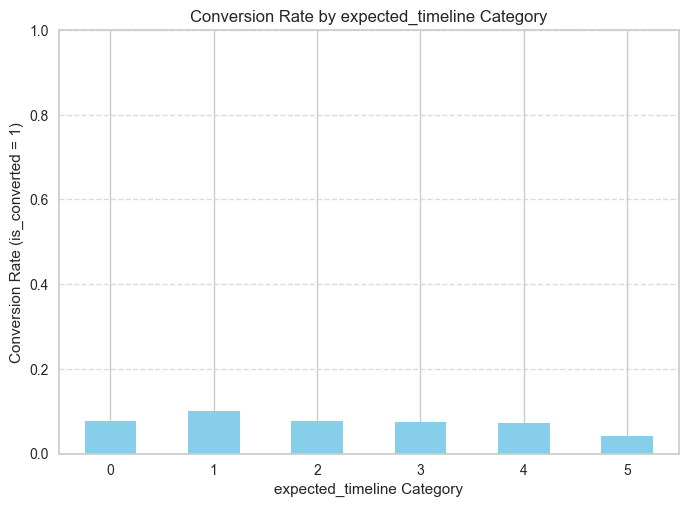

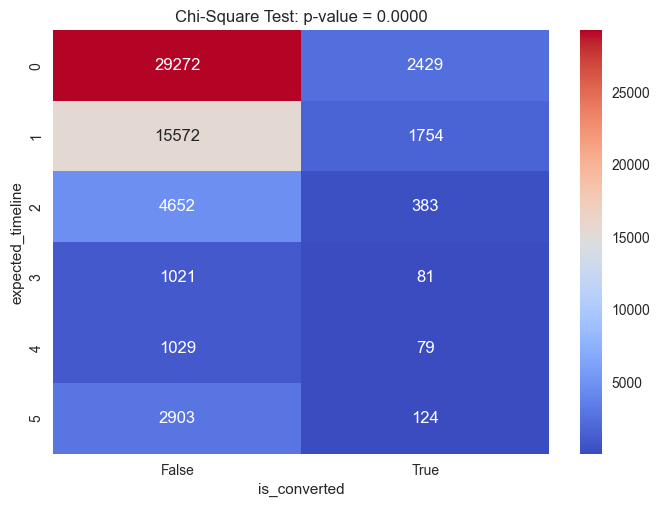

In [36]:
#특수문자와 공백을 모두 제거
def remove_special_characters(text):
    if isinstance(text, str):
        # 정규표현식을 사용하여 공백과 특수문자를 제거하고 모든 공백을 없앰
        cleaned_text = re.sub(r'[^a-zA-Z0-9가-힣]', '', text)
        return cleaned_text.strip()  # 양쪽 공백 제거 후 반환
    else:
        return text

expected_timeline_class = ['lessthan3months', 'morethanayear','6months9months', '3months6months', '9months1year']
label = {'lessthan3months' : 1, '3months6months' : 2,'6months9months' : 3, '9months1year' : 4, 'morethanayear' : 5}
#공백과 특수문자 제거
train['expected_timeline'] = train['expected_timeline'].apply(remove_special_characters)
submission['expected_timeline'] = submission['expected_timeline'].apply(remove_special_characters)

#label encoding
train['expected_timeline'] = train['expected_timeline'].apply(lambda x: label[x] if x in label else 0)
submission['expected_timeline'] = submission['expected_timeline'].apply(lambda x: label[x] if x in label else 0)

conversion_rates = train.groupby('expected_timeline')['is_converted'].mean()
chi2, p, _, _ = chi2_contingency(pd.crosstab(train['expected_timeline'], train['is_converted']))

# 그래프 생성
conversion_rates.plot(kind='bar', color='skyblue')
plt.title('Conversion Rate by expected_timeline Category')
plt.xlabel('expected_timeline Category')
plt.ylabel('Conversion Rate (is_converted = 1)')
plt.xticks(rotation=0)
plt.ylim(0, 1)  # y축 범위를 0부터 1까지로 설정
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 시각화
sns.heatmap(pd.crosstab(train['expected_timeline'], train['is_converted']), annot=True, cmap='coolwarm', fmt='d')
plt.title(f'Chi-Square Test: p-value = {p:.4f}')
plt.xlabel('is_converted')
plt.ylabel('expected_timeline')
plt.show()
#원 핫 인코딩 
encoder = OneHotEncoder(drop='first')
#train 데이터 인코딩
encoder.fit(train[['expected_timeline']])
train_encoded = encoder.transform(train[['expected_timeline']])
#submission 데이터 인코딩
submission_encoded = encoder.transform(submission[['expected_timeline']])

#인코딩 데이터 결합
train_encoded_df = pd.DataFrame(train_encoded.toarray(), columns=encoder.get_feature_names_out(['expected_timeline']))
submission_encoded_df = pd.DataFrame(submission_encoded.toarray(), columns=encoder.get_feature_names_out(['expected_timeline']))

train = pd.concat([train,train_encoded_df],axis=1)
submission = pd.concat([submission,submission_encoded_df],axis=1)

# expected_timeline 삭제 
train.drop(columns=['expected_timeline'],inplace=True)
submission.drop(columns=['expected_timeline'],inplace=True)

# 22 ver_cus

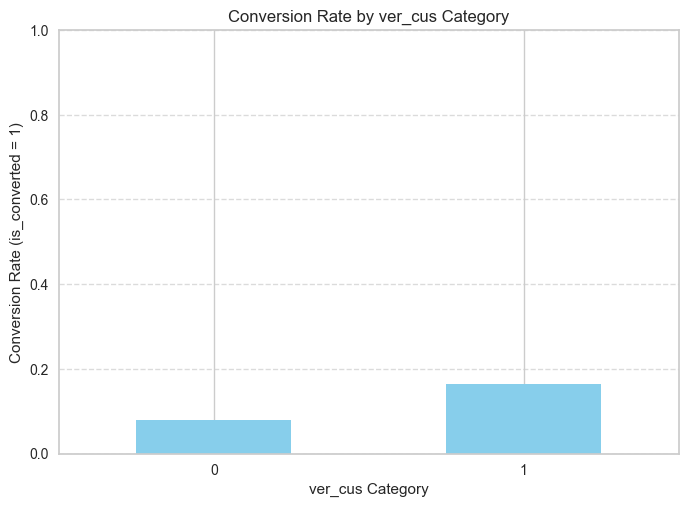

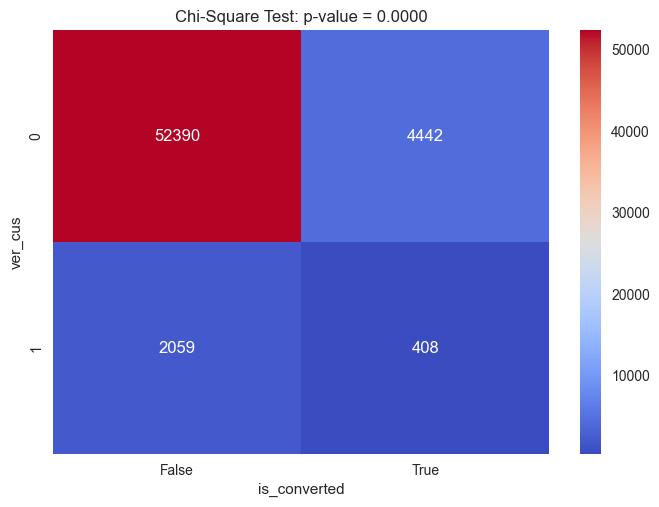

In [37]:
conversion_rates = train.groupby('ver_cus')['is_converted'].mean()
chi2, p, _, _ = chi2_contingency(pd.crosstab(train['ver_cus'], train['is_converted']))

# 그래프 생성
conversion_rates.plot(kind='bar', color='skyblue')
plt.title('Conversion Rate by ver_cus Category')
plt.xlabel('ver_cus Category')
plt.ylabel('Conversion Rate (is_converted = 1)')
plt.xticks(rotation=0)
plt.ylim(0, 1)  # y축 범위를 0부터 1까지로 설정
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 시각화
sns.heatmap(pd.crosstab(train['ver_cus'], train['is_converted']), annot=True, cmap='coolwarm', fmt='d')
plt.title(f'Chi-Square Test: p-value = {p:.4f}')
plt.xlabel('is_converted')
plt.ylabel('ver_cus')
plt.show()

# 23 ver_pro

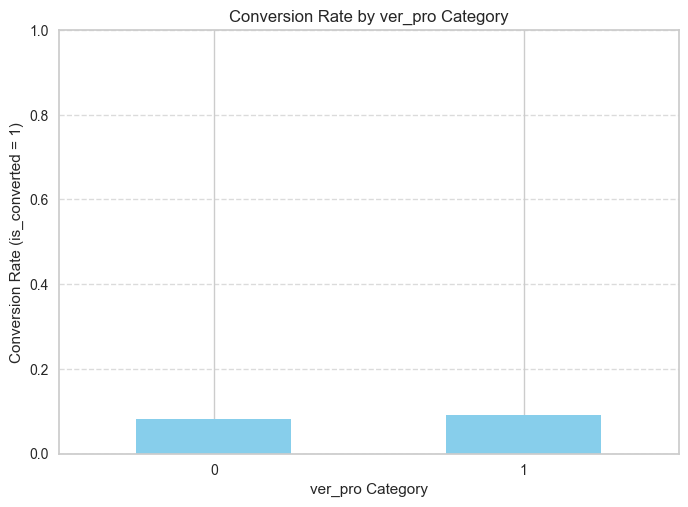

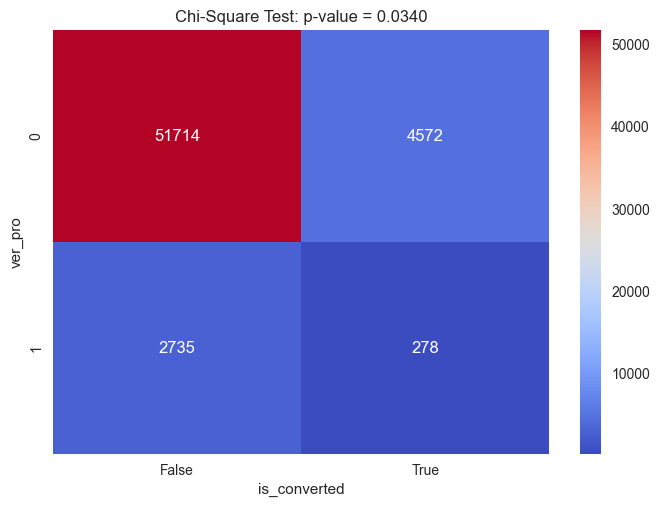

In [38]:
conversion_rates = train.groupby('ver_pro')['is_converted'].mean()
chi2, p, _, _ = chi2_contingency(pd.crosstab(train['ver_pro'], train['is_converted']))

# 그래프 생성
conversion_rates.plot(kind='bar', color='skyblue')
plt.title('Conversion Rate by ver_pro Category')
plt.xlabel('ver_pro Category')
plt.ylabel('Conversion Rate (is_converted = 1)')
plt.xticks(rotation=0)
plt.ylim(0, 1)  # y축 범위를 0부터 1까지로 설정
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 시각화
sns.heatmap(pd.crosstab(train['ver_pro'], train['is_converted']), annot=True, cmap='coolwarm', fmt='d')
plt.title(f'Chi-Square Test: p-value = {p:.4f}')
plt.xlabel('is_converted')
plt.ylabel('ver_pro')
plt.show()

# 24 ver_win_rate_x(결측치 0으로 처리)
- fillna(0)

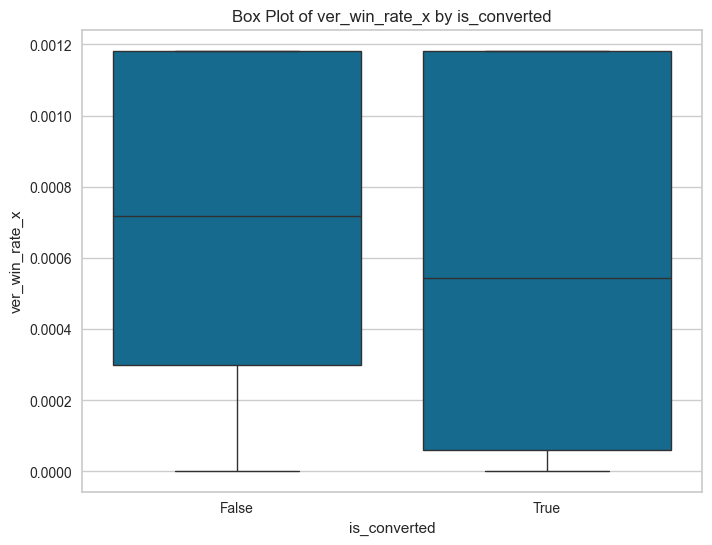

ver_win_rate_x 와 is_converted의 상관계수 : 

                ver_win_rate_x  is_converted
ver_win_rate_x        1.000000     -0.048552
is_converted         -0.048552      1.000000




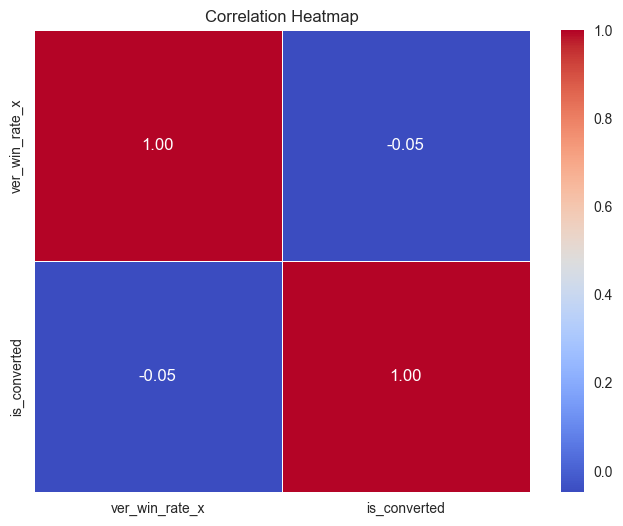

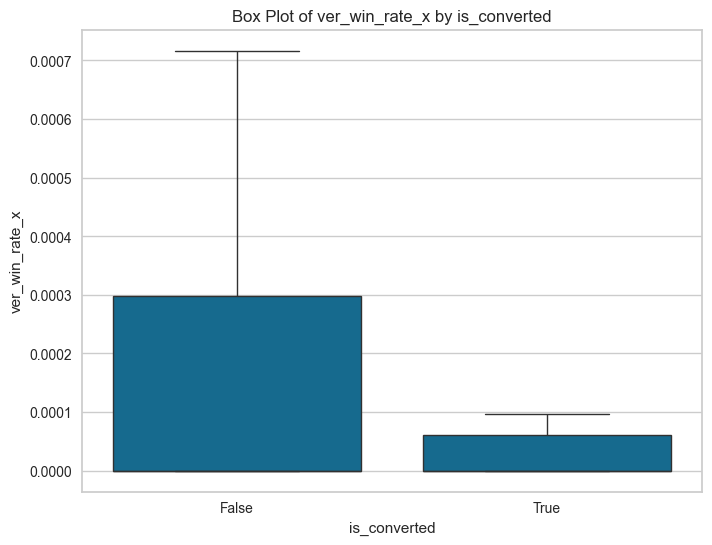

ver_win_rate_x 와 is_converted의 상관계수 : 

                ver_win_rate_x  is_converted
ver_win_rate_x        1.000000     -0.031182
is_converted         -0.031182      1.000000




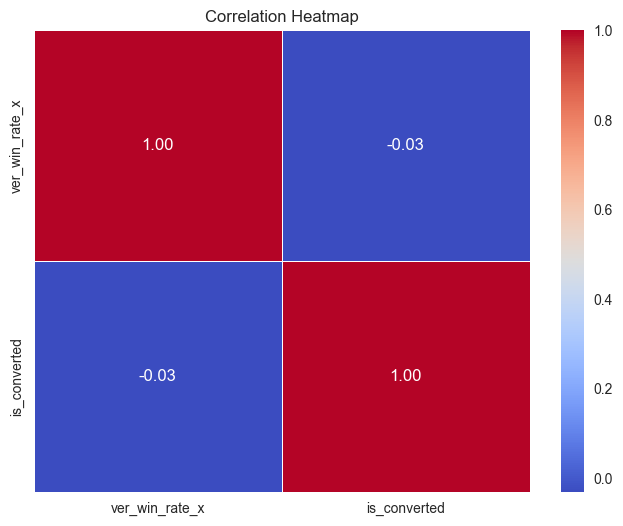

In [39]:
# 이상치 및 결측치 제거
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_converted', y='ver_win_rate_x',showfliers=False, data=train[~train['ver_win_rate_x'].isna()])
plt.title('Box Plot of ver_win_rate_x by is_converted')
plt.xlabel('is_converted')
plt.ylabel('ver_win_rate_x')
plt.show()

cor = train[['ver_win_rate_x', 'is_converted']].corr()
print(f'ver_win_rate_x 와 is_converted의 상관계수 : \n\n{cor}\n\n')

#hitmap
plt.figure(figsize=(8, 6))
sns.heatmap(train[~train['ver_win_rate_x'].isna()][['ver_win_rate_x','is_converted']].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

train['ver_win_rate_x'].fillna(0,inplace=True)
submission['ver_win_rate_x'].fillna(0,inplace=True)

# 이상치 및 결측치 제거
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_converted', y='ver_win_rate_x',showfliers=False, data=train)
plt.title('Box Plot of ver_win_rate_x by is_converted')
plt.xlabel('is_converted')
plt.ylabel('ver_win_rate_x')
plt.show()

cor = train[['ver_win_rate_x', 'is_converted']].corr()
print(f'ver_win_rate_x 와 is_converted의 상관계수 : \n\n{cor}\n\n')

#hitmap
plt.figure(figsize=(8, 6))
sns.heatmap(train[['ver_win_rate_x','is_converted']].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

train.drop(columns=['ver_win_rate_x'],inplace=True)
submission.drop(columns=['ver_win_rate_x'],inplace=True)

# 25 ver_win_ratio_per_bu(결측치 0으로 처리)

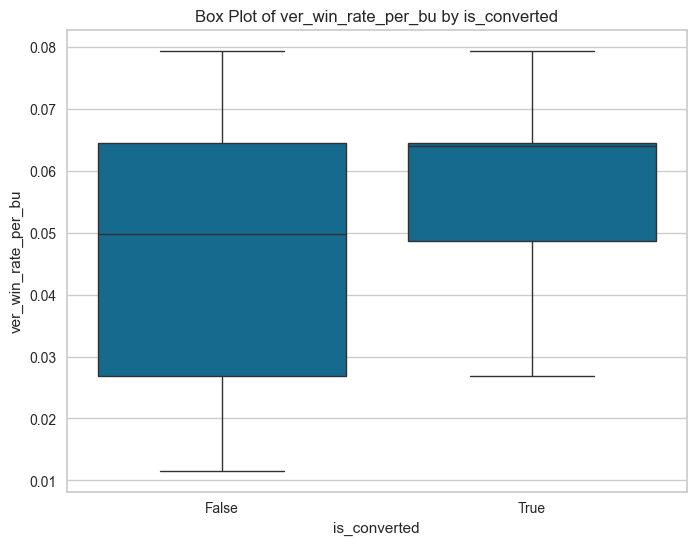

ver_win_rate_per_bu 와 is_converted의 상관계수 : 

                      ver_win_ratio_per_bu  is_converted
ver_win_ratio_per_bu              1.000000      0.109572
is_converted                      0.109572      1.000000




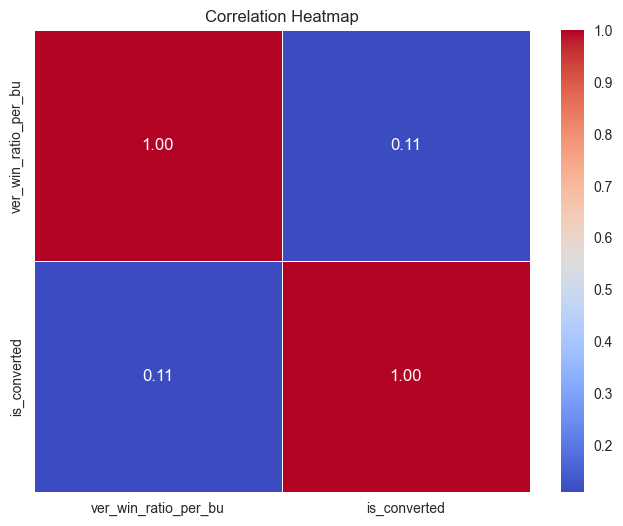

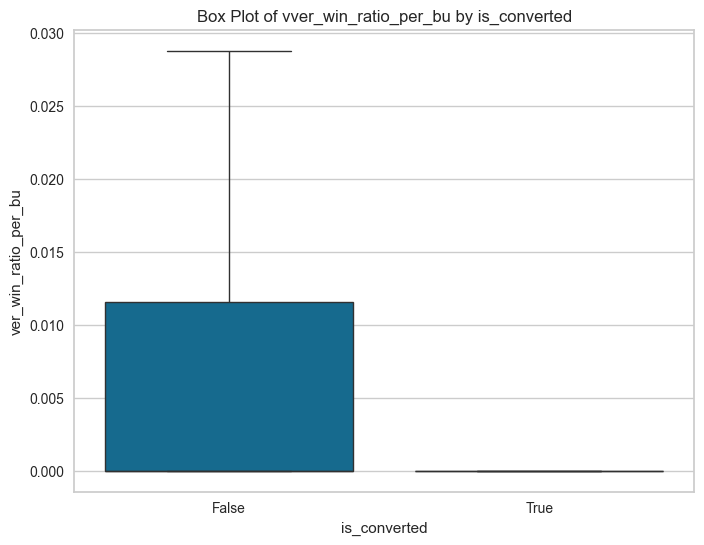

ver_win_rate_x 와 is_converted의 상관계수 : 

                      ver_win_ratio_per_bu  is_converted
ver_win_ratio_per_bu              1.000000     -0.007443
is_converted                     -0.007443      1.000000




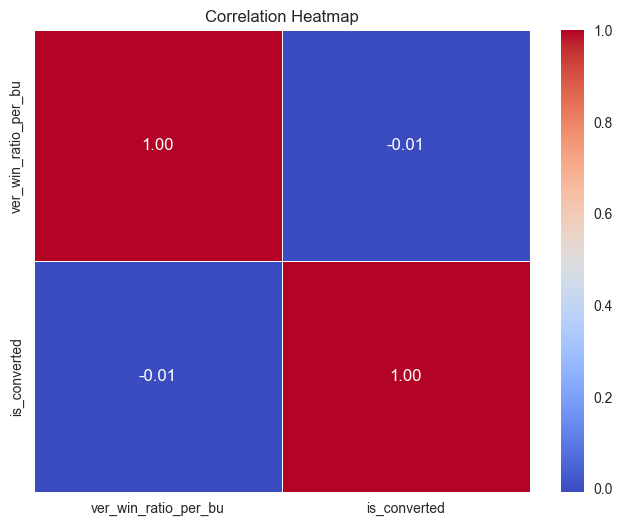

In [40]:
# 이상치 및 결측치 제거
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_converted', y='ver_win_ratio_per_bu',showfliers=False, data=train[~train['ver_win_ratio_per_bu'].isna()])
plt.title('Box Plot of ver_win_rate_per_bu by is_converted')
plt.xlabel('is_converted')
plt.ylabel('ver_win_rate_per_bu')
plt.show()

cor = train[['ver_win_ratio_per_bu', 'is_converted']].corr()
print(f'ver_win_rate_per_bu 와 is_converted의 상관계수 : \n\n{cor}\n\n')

#hitmap
plt.figure(figsize=(8, 6))
sns.heatmap(train[~train['ver_win_ratio_per_bu'].isna()][['ver_win_ratio_per_bu','is_converted']].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

train['ver_win_ratio_per_bu'].fillna(0,inplace=True)
submission['ver_win_ratio_per_bu'].fillna(0,inplace=True)

# 이상치 및 결측치 제거
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_converted', y='ver_win_ratio_per_bu',showfliers=False, data=train)
plt.title('Box Plot of vver_win_ratio_per_bu by is_converted')
plt.xlabel('is_converted')
plt.ylabel('ver_win_ratio_per_bu')
plt.show()

cor = train[['ver_win_ratio_per_bu', 'is_converted']].corr()
print(f'ver_win_rate_x 와 is_converted의 상관계수 : \n\n{cor}\n\n')

#hitmap
plt.figure(figsize=(8, 6))
sns.heatmap(train[['ver_win_ratio_per_bu','is_converted']].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

train.drop(columns=['ver_win_ratio_per_bu'],inplace=True)
submission.drop(columns=['ver_win_ratio_per_bu'],inplace=True)

# 26 business_area(결측치 0으로 처리)

In [41]:
train.drop(columns=['business_area'],inplace=True)
submission.drop(columns=['business_area'],inplace=True)

# 27 business_subarea
drop

In [42]:
train.drop(columns=['business_subarea'],inplace=True)
submission.drop(columns=['business_subarea'],inplace=True)

# 28 lead_owner

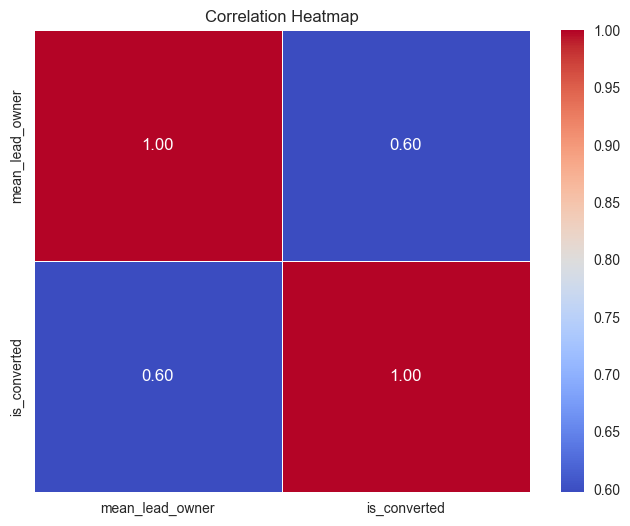

In [43]:
#lead_owner 형변환 int -> str
train['lead_owner'] = train['lead_owner'].astype(str)
submission['lead_owner'] = submission['lead_owner'].astype(str)

# lead_owner_cnt 컬럼 생성
train['lead_owner_cnt'] = train.groupby(['lead_owner'])['lead_owner'].transform('count')

#빈도 수 (lead_owner_cnt)가 5 이하인 데이터는 lead_owner를 etc로 통일
n = 5
for i in range(1,n+1):
    train.loc[train['lead_owner_cnt'] == i,'lead_owner'] = 'etc'

# lead_owner 별 평균 영업 성공률 계산한 mean_lead_owner 추가
train['mean_lead_owner'] = train.groupby('lead_owner')['is_converted'].transform('mean')
mean_customer_idx_unique = train.drop_duplicates(subset=['lead_owner'])[['lead_owner', 'mean_lead_owner']]
submission = submission.merge(mean_customer_idx_unique,on='lead_owner',how='left')
#submission에서 매칭되지 않은(etc에 속한 lead_owner 또는 submission에만 존재하는 lead_owner) mean_customer_idx의 값은 etc에 해당하는 값으로 대체
submission['mean_lead_owner'].fillna(train[train['lead_owner']=='etc']['mean_lead_owner'].iloc[0],inplace= True)

train.drop(columns = ['lead_owner','lead_owner_cnt'],inplace=True)
submission.drop(columns = ['lead_owner'],inplace= True)

plt.figure(figsize=(8, 6))
sns.heatmap(train[['mean_lead_owner','is_converted']].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [44]:
train_etc = train[train['customer_idx']=='etc']
train_else = train[train['customer_idx']!='etc']

train_else = train_else.groupby('is_converted').head(100)
train = pd.concat([train_etc, train_else])

# 전처리 데이터 정보

In [45]:
train.dtypes

bant_submit                           float64
com_reg_ver_win_rate                  float64
customer_idx                           object
historical_existing_cnt               float64
id_strategic_ver                      float64
it_strategic_ver                      float64
idit_strategic_ver                    float64
customer_job                           object
lead_desc_length                        int64
product_modelname                       int64
ver_cus                                 int64
ver_pro                                 int64
is_converted                             bool
customer_continent_Asia               float64
customer_continent_Europe             float64
customer_continent_North America      float64
customer_continent_Oceania            float64
customer_continent_South America      float64
customer_continent_etc                float64
business_unit_ID                      float64
business_unit_IT                      float64
business_unit_etc                 

# 모델 학습

In [47]:
# 레이블 인코딩 함수 정의
def label_encoding(series: pd.Series) -> pd.Series:
    my_dict = {}
    series = series.astype(str)
    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)
    return series

# 레이블 인코딩할 칼럼들
label_columns = [
    "bant_submit", "com_reg_ver_win_rate", "customer_idx", "customer_job",
    "product_modelname", "business_unit_ID", "business_unit_IT", "business_unit_etc",
    "mean_customer_idx", "customer_type_End Customer", "customer_type_Engineer",
    "customer_type_Other", "customer_type_Specifier/Influencer", "enterprise_SMB",
    "customer_position_power", "response_region_Asia", "response_region_Europe",
    "response_region_Latin America", "response_region_Middle East", "response_region_North America",
    "response_region_Oceania", "expected_timeline_1", "expected_timeline_2", "expected_timeline_3",
    "expected_timeline_4", "expected_timeline_5", "mean_lead_owner", "customer_continent_Asia",
    "customer_continent_Europe", "customer_continent_North America", "customer_continent_Oceania",
    "customer_continent_South America", "customer_continent_etc"
]
# 전체 데이터셋에 레이블 인코딩 적용
df_all = pd.concat([train[label_columns], submission[label_columns]])

for col in label_columns:
    df_all[col] = label_encoding(df_all[col])

# 다시 학습 및 테스트 데이터로 분리
train[label_columns] = df_all.iloc[:len(train)][label_columns]
submission[label_columns] = df_all.iloc[len(train):][label_columns]

# 데이터 분리
X = train.drop(["is_converted"], axis=1)
y = train["is_converted"]

In [48]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

# 데이터 불균형 처리 (SMOTE 적용)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 학습 데이터를 훈련 데이터와 검증 데이터로 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 모델 선택 (결정 트리, max_depth=5로 제한)
model = DecisionTreeClassifier(random_state=42, max_depth=5)

# 학습
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_valid)

In [49]:
# 평가 지표 출력
print("Accuracy:", accuracy_score(y_valid, y_pred))
print("Precision:", precision_score(y_valid, y_pred))
print("Recall:", recall_score(y_valid, y_pred))
print("F1 Score:", f1_score(y_valid, y_pred))

# 교차 검증을 통한 과적합 검사
cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='accuracy')
print("교차 검증 정확도 평균:", cv_scores.mean())

# 테스트 데이터 예측
test_pred = model.predict(submission.drop(["is_converted", "id"], axis=1))
print("True로 예측된 개수:", sum(test_pred))

Accuracy: 0.9110704591053936
Precision: 0.9021965317919075
Recall: 0.9219137625516834
F1 Score: 0.9119485831142272
교차 검증 정확도 평균: 0.8956870648462892
True로 예측된 개수: 2126


In [ ]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred
df_sub.to_csv("submission.csv")